Data source: https://www.kaggle.com/datasets/carrie1/ecommerce-data?resource=download

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

# Setup

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import snowflake.connector

In [2]:
creds = np.loadtxt('C:/Users/ryana/.jupyter/snow_creds.txt', dtype="U", delimiter=",")
user= creds[0]
password = creds[1]
account= creds[2]

In [3]:
connection = snowflake.connector.connect(
    user=user,
    password=password,
    account=account)
cursor = connection.cursor()
query = 'SELECT * FROM UK_CUSTOMER_DATA.CUSTOMER_DATA.TRANSACTIONS'
cursor.execute(query)
data_raw = cursor.fetch_pandas_all()

In [4]:
data = data_raw.copy().rename(columns=str.lower)

In [5]:
data

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


# Exploration

## Full Dataset

### Missing Values

Some descriptions are missing. Almost 25% of customer IDs are missing.

In [6]:
data.isna().sum()

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     135080
country             0
dtype: int64

### Customer ID

There are 4372 unique customers.

In [7]:
data['customerid'].nunique()

4372

In [8]:
#divide the dataset into those with customer IDs and those without
data_with_id = data[~data['customerid'].isna()]
data_no_id = data[data['customerid'].isna()]

**Every invoice is associated with a single customer.** Every `invoiceno` only has one `customerid` associated with it. If an invoice had more than one customer, there would be more rows in the below table than there are unique invoice numbers.

In [9]:
data_with_id.groupby(['invoiceno','customerid']).count()

,,stockcode,description,quantity,invoicedate,unitprice,country
invoiceno,customerid,,,,,,
536365,17850,7,7,7,7,7,7
536366,17850,2,2,2,2,2,2
536367,13047,12,12,12,12,12,12
536368,13047,4,4,4,4,4,4
536369,13047,1,1,1,1,1,1
...,...,...,...,...,...,...,...
C581484,16446,1,1,1,1,1,1
C581490,14397,2,2,2,2,2,2
C581499,15498,1,1,1,1,1,1


In [10]:
data_with_id['invoiceno'].nunique()

22190

Unfotunately, there are no invoice numbers shared between the data with customer IDs and the data without customer IDs, so **we can't use shared invoice numbers to fill in any of the missing customer IDs**.

In [11]:
data_no_id[data_no_id['invoiceno'].isin(data_with_id['invoiceno'].unique())]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country


None of the rows that have a customer ID are missing a description.

In [12]:
data_with_id.isna().sum()

invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
country        0
dtype: int64

## Data With Customer IDs

We'll only be working with data including customer IDs for customer segmentation, so we'll further explore this part of the dataset.

In [13]:
data = data_with_id

### Invoices

There are 22,190 unique invoices. Most invoices have only a few transactions (the quartiles are 3, median 12, and 24), but some very large invoices (max 542) drag the average up to around 18.

In [14]:
data['invoiceno'].groupby(data['invoiceno']).count().describe()

count    22190.000000
mean        18.333889
std         23.892111
min          1.000000
25%          3.000000
50%         12.000000
75%         24.000000
max        542.000000
Name: invoiceno, dtype: float64

Most invoices are associated with one timestamp, but 31 invoices are associated with two times. In these cases, the times are sequential minutes. See invoice 578548 for an example:

In [15]:
#invoice associated with two sequential times
data[data['invoiceno']=='578548']['invoicedate'].value_counts()

2011-11-24 15:02:00    50
2011-11-24 15:03:00     2
Name: invoicedate, dtype: int64

In [16]:
#no invoice is associated with more than two times
dates_per_invoice = data.groupby('invoiceno')['invoicedate'].nunique().sort_values(ascending=False)
dates_per_invoice[dates_per_invoice>1]

invoiceno
578548     2
571735     2
541631     2
542806     2
547690     2
544926     2
546986     2
550320     2
541849     2
C545569    2
540185     2
550645     2
553556     2
554116     2
563245     2
549245     2
541596     2
553375     2
541816     2
550333     2
536591     2
543179     2
567183     2
562128     2
543777     2
542217     2
545460     2
553199     2
544667     2
558086     2
576057     2
Name: invoicedate, dtype: int64

In [17]:
#all times for invoices associated with two times are sequential minutes
data[data['invoiceno'].isin(dates_per_invoice[dates_per_invoice>1].index)].groupby('invoiceno')['invoicedate'].unique().tolist()

[array(['2010-12-01T16:57:00.000000000', '2010-12-01T16:58:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-01-05T13:40:00.000000000', '2011-01-05T13:41:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-01-19T16:18:00.000000000', '2011-01-19T16:19:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-01-20T10:47:00.000000000', '2011-01-20T10:48:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-01-21T15:56:00.000000000', '2011-01-21T15:57:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-01-23T13:33:00.000000000', '2011-01-23T13:34:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-01-26T12:35:00.000000000', '2011-01-26T12:36:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-02-01T11:19:00.000000000', '2011-02-01T11:20:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-02-04T10:31:00.000000000', '2011-02-04T10:32:00.000000000'],
       dtype='datetime64[ns]'),
 array(['2011-02-11T16:19:00.00000000

### Stockcodes and Desciptions

Some stock codes are associated with multiple descriptions, and some descriptions are associated with multiple stock codes.

In [18]:
#find stockcodes with multiple descriptions
data.groupby('stockcode')['description'].nunique().sort_values(ascending=False)

stockcode
23236     4
23196     4
22776     3
23203     3
17107D    3
         ..
22357     1
22358     1
22359     1
22360     1
POST      1
Name: description, Length: 3684, dtype: int64

In [19]:
# different descriptions for the stock code with the most descriptions
data[data['stockcode']=='23236']['description'].value_counts()

STORAGE TIN VINTAGE DOILY      181
DOILEY STORAGE TIN             118
DOILEY BISCUIT TIN              13
STORAGE TIN VINTAGE DOILEY       1
Name: description, dtype: int64

In [20]:
#find descriptions associated with multiple stock codes
data.groupby('description')['stockcode'].nunique().sort_values(ascending=False)

description
METAL SIGN,CUPCAKE SINGLE HOOK      3
SQUARE CHERRY BLOSSOM CABINET       2
RETRO PLASTIC 70'S TRAY             2
PINK FLOWERS RABBIT EASTER          2
ROUND BLUE CLOCK WITH SUCKER        2
                                   ..
FOUR RABBIT EASTER DECORATIONS      1
FRAPPUCINO SCARF KNITTING KIT       1
FREESTYLE CANVAS ART PICTURE        1
FRENCH BATHROOM SIGN BLUE METAL     1
ZINC WIRE SWEETHEART LETTER TRAY    1
Name: stockcode, Length: 3896, dtype: int64

In [21]:
# different stock codes for the description with the most stock codes
data[data['description']=='METAL SIGN,CUPCAKE SINGLE HOOK']['stockcode'].value_counts()

82613B    47
82613C    39
82613A    15
Name: stockcode, dtype: int64

Transactions with negative quantities have 'C' at the beginning of the `invoiceno`.

In [35]:
data[data['quantity']<0]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,totalprice
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,-1.25


In [36]:
data[data['invoiceno'].str.contains('C')]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,totalprice
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,-1.25


### Quantity and Unit Price

Most quantities and unit prices fall within a small range, but there are some big outliers.

In [22]:
data[['quantity','unitprice']].describe()

,quantity,unitprice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


<AxesSubplot:xlabel='quantity', ylabel='unitprice'>

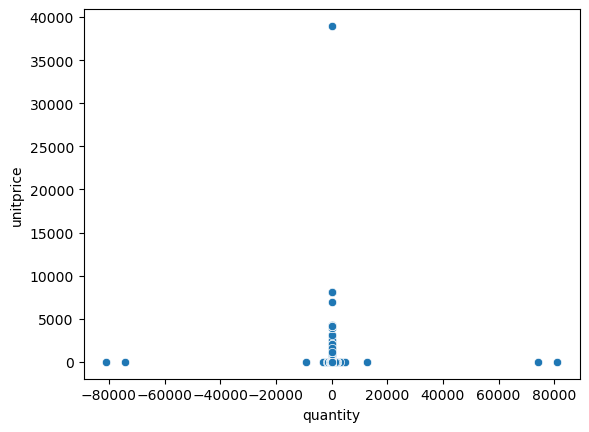

In [23]:
sns.scatterplot(data=data, x='quantity', y='unitprice')

### County

There are 37 unique countries, mostly in Europe. 88% of transactions are from the United Kingdom.

In [24]:
# country value counts
data['country'].value_counts(normalize=True)

United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RSA       

# Analysis

## RFM

In [25]:
#recency
rfm = pd.DataFrame(data.groupby('customerid')['invoicedate'].max())
rfm

,invoicedate
customerid,
12346,2011-01-18 10:17:00
12347,2011-12-07 15:52:00
12348,2011-09-25 13:13:00
12349,2011-11-21 09:51:00
12350,2011-02-02 16:01:00
...,...
18280,2011-03-07 09:52:00
18281,2011-06-12 10:53:00
18282,2011-12-02 11:43:00


In [26]:
rfm['recency'] = (rfm['invoicedate'] - pd.to_datetime(min(rfm['invoicedate']))).dt.days
rfm

,invoicedate,recency
customerid,,
12346,2011-01-18 10:17:00,48
12347,2011-12-07 15:52:00,371
12348,2011-09-25 13:13:00,298
12349,2011-11-21 09:51:00,354
12350,2011-02-02 16:01:00,63
...,...,...
18280,2011-03-07 09:52:00,95
18281,2011-06-12 10:53:00,193
18282,2011-12-02 11:43:00,366


In [27]:
rfm = rfm.drop('invoicedate',axis=1)

In [28]:
#frequency
freq = pd.DataFrame(data.groupby('customerid')['invoiceno'].nunique()).rename(columns={'invoiceno':'frequency'})
freq

,frequency
customerid,
12346,2
12347,7
12348,4
12349,1
12350,1
...,...
18280,1
18281,1
18282,3


In [30]:
rfm = rfm.merge(freq, on='customerid')

In [31]:
#monetary value
data['totalprice'] = data['quantity']*data['unitprice']
data

C:\Users\ryana\AppData\Local\Temp\ipykernel_7724\3701296637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['totalprice'] = data['quantity']*data['unitprice']


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,totalprice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [32]:
monetary = pd.DataFrame(data.groupby('customerid')['totalprice'].sum().round(2)).rename(columns={'totalprice':'monetary'})
monetary

,monetary
customerid,
12346,0.00
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40
...,...
18280,180.60
18281,80.82
18282,176.60


In [38]:
data[data['customerid']=='12346']

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,totalprice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6


In [33]:
rfm = rfm.merge(monetary, on='customerid')

In [39]:
rfm

,recency,frequency,monetary
customerid,,,
12346,48,2,0.00
12347,371,7,4310.00
12348,298,4,1797.24
12349,354,1,1757.55
12350,63,1,334.40
...,...,...,...
18280,95,1,180.60
18281,193,1,80.82
18282,366,3,176.60
